# Imaging
Run the following hidden cells for preparing the code environment

In [1]:
%pylab inline
import pandas
from tqdm.notebook import tqdm
import h5py
import os
import pandas

Populating the interactive namespace from numpy and matplotlib


Import the BrightEyes-TTM library (`libttp`)

In [2]:
import libttp.ttp as ttp


# Select Data & parameters

In [10]:
filenameToRead="/home/mdonato/Downloads/14_zoom_FOV15_512x512_200us.ttr"


In [27]:
CHANNELS=25                              # Number of CHANNELS
sysclk_MHz=240.                          # FPGA system clock (MHz)
npixel = 512                             # Image size (pixels)
laser_MHz=80.                            # Laser repetition rate (MHz)
laser_factor=1                           # Adimensional number to account for laser actual repetiton frequency (default = 1)
dwell_time = 50                          # Pixel dwell time (us)
list_of_channels = np.arange(0,CHANNELS) # List of channels to analyse (it must be a numpy.array)
kC4=48                                   # Time width of TCSPC histogram bin in [ps] (default = 48ps)

#### Define the output HDF5 filename 

In [12]:
filenameHDF5=filenameToRead+".h5"

## Read the Raw file (protocol v2.0) and create the dataframe

In [13]:
df = ttp.readNewProtocolFileToPandas(
    filenameIn=filenameToRead,
    reorder_channels=True, #needed for 25 channel otherwise the channel will not respect the order
    CHANNELS=CHANNELS,
    force_16bit_step=True)

0 -1
File total size in uint16 units: 149726248
-1
File read size in uint16 units: 149726248
Channels: 25
MAXWORD: 30
28852539
data read
i) added column
ii) added pixel, line, frame
iii) added 'steps' bytes
         assume step 16-bit long
iv) calculate 'step'
Index(['id_0', 'id_1', 'id_2', 'id_3', 'id_4', 'id_5', 'id_6', 'id_7', 'id_8',
       'id_9', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'valid_tdc_0',
       'valid_tdc_1', 'valid_tdc_2', 'valid_tdc_3', 'valid_tdc_4',
       'valid_tdc_5', 'valid_tdc_6', 'valid_tdc_7', 'valid_tdc_8',
       'valid_tdc_9', 'valid_tdc_10', 'valid_tdc_11', 'valid_tdc_12',
       'valid_tdc_13', 'valid_tdc_14', 'valid_tdc_15', 'valid_tdc_16',
       'valid_tdc_17', 'valid_tdc_18', 'valid_tdc_19', 'valid_tdc_20',
       'valid_tdc_21', 'valid_tdc_22', 'valid_tdc_23', 'valid_tdc_24',
       'valid_dummy

#### Check if any `valid_laser` signals is present

In [14]:
count_L=count_nonzero(df["valid_tdc_L"])
if count_L==0:
    print("No valid_tdc_L found. Check your Laser SYNC.")
else:
    print("valid_tdc_L", count_L)

valid_tdc_L 15440341


#### A quick preview of the total counts on each channel

[[ 308437.  540666.  516823.  482632.  348259.]
 [ 415735.  779450.  972624.  889469.  619580.]
 [ 541080. 1059215. 1378896. 1128908.  671962.]
 [ 495855.  910601. 1220114.  971682.  636053.]
 [ 429716.  573104.  696498.  597887.  426957.]]


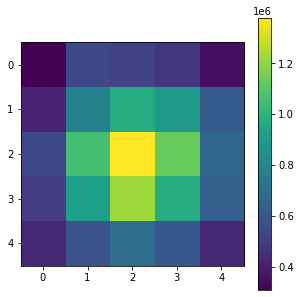

In [15]:
valids=np.zeros(CHANNELS)
for i in range(0,CHANNELS):
    valids[i]=count_nonzero(df["valid_tdc_%d"%i])
if CHANNELS==25:
    figure(figsize(5,5))
    valids=asarray(valids).reshape((5,5))
    imshow(valids)
    colorbar()
elif CHANNELS==49:
    figure(figsize(5,5))
    valids=asarray(valids).reshape((7,7))
    imshow(valids)
    colorbar()

print(valids)


#### Set some useful calculate some useful parameter

In [16]:
laser_MHz=laser_MHz*laser_factor
laser_Hz=laser_MHz*10**6
max_counter=2**16-1
sysclk_ps=1000000./sysclk_MHz #ps
print("SysClk ps:", sysclk_ps)
laser_ps=1000000./laser_MHz #ps
print("LaserClk ps:", laser_ps)
ratio=sysclk_MHz/laser_MHz
sysclk_ps=1e6/sysclk_MHz
laser_ps=1e6/laser_MHz
nbins=int(round(laser_ps/kC4))
print("actual kC4", laser_ps/nbins)

SysClk ps: 4166.666666666667
LaserClk ps: 12500.0
actual kC4 48.07692307692308


# Data frame conversion to H5 format

In [17]:
myReturn=ttp.convertFromPandasDataFrame( df, filenameOutputHDF5=filenameHDF5 ,
                    sysclk_MHz = sysclk_MHz,
                    laser_MHz = laser_MHz,
                    list_of_channels=list_of_channels,
                    compressionLevel=0,
                    ignorePixelLineFrame = False,
                    coincidence_analysis = False,
                    kC4=kC4
                        )

Calculate rates 
Calculate cumulative step 
Add cumulativeStep
Acquisition lasted:  54.083897416666666 s
Scan_enable 9.0 ratio 3.119309642708035e-07 rate 0.16640812570631294
line_enable 37362.0 ratio 0.0012949294096761955 rate 690.8155991821404
pixel_enable 262144.0 ratio 0.009085647855311723 rate 4846.987967239522
Laser 15440341.0 ratio 0.5351467174222246 rate 285488.6895640375
Calculate totalphotons 
start the sum
sum done
kC4<=== 48
sysclk_ps<=== 4166.666666666667
kC4<=== 47.89272030651341
Start process
Start analysisForImg
Arrays copied into analysisForImg


Current frame: 1 	: : 29141025it [00:07, 4050493.87it/s]                        


Total Frame: 1
New HDF5 written
total_photon        uint8
cumulative_step     int64
arr_px             uint16
arr_px_corr        uint16
arr_py             uint16
arr_frame          uint16
dtype: object


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Start conversion of 0 channel
t_0 valid_tdc_0
..
...



 38%|█████████▉                | 5965962/15699959 [00:00<00:00, 56583809.96it/s]

starting loop



15856899it [00:00, 55822732.51it/s]                                             
  4%|█▊                                          | 1/25 [00:05<02:15,  5.65s/it]

Data ready, conversion to array
Adding keys to HDF5...  "ch_0"
t_0      int16
t_L      int16
dS_0    uint16
dtype: object
Start conversion of 1 channel
t_1 valid_tdc_1
..
...



 25%|██████▍                   | 3967600/15870469 [00:00<00:00, 39153376.71it/s]

starting loop



 50%|████████████▉             | 7935200/15870469 [00:00<00:00, 38552058.98it/s]
16029104it [00:00, 40948056.46it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_1"


  8%|███▌                                        | 2/25 [00:11<02:12,  5.77s/it]

t_1      int16
t_L      int16
dS_1    uint16
dtype: object
Start conversion of 2 channel
t_2 valid_tdc_2
..
...



 32%|████████▎                 | 5081856/15880856 [00:00<00:00, 49845653.82it/s]

starting loop



 64%|███████████████▉         | 10163712/15880856 [00:00<00:00, 48103292.30it/s]
16039608it [00:00, 45660127.08it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_2"


 12%|█████▎                                      | 3/25 [00:17<02:06,  5.77s/it]

t_2      int16
t_L      int16
dS_2    uint16
dtype: object
Start conversion of 3 channel
t_3 valid_tdc_3
..
...



 27%|███████                   | 4275963/15836904 [00:00<00:00, 42558662.96it/s]

starting loop



 54%|██████████████            | 8551926/15836904 [00:00<00:00, 41318976.07it/s]
15995269it [00:00, 38228908.83it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_3"


 16%|███████                                     | 4/25 [00:23<02:01,  5.77s/it]

t_3      int16
t_L      int16
dS_3    uint16
dtype: object
Start conversion of 4 channel
t_4 valid_tdc_4
..
...



 38%|█████████▉                | 5981846/15741734 [00:00<00:00, 59159682.73it/s]

starting loop



15899117it [00:00, 41965784.61it/s]                                             
 20%|████████▊                                   | 5/25 [00:28<01:54,  5.72s/it]

Data ready, conversion to array
Adding keys to HDF5...  "ch_4"
t_4      int16
t_L      int16
dS_4    uint16
dtype: object
Start conversion of 5 channel
t_5 valid_tdc_5
..
...



 29%|███████▌                  | 4575040/15776034 [00:00<00:00, 44613279.92it/s]

starting loop



 62%|████████████████          | 9781120/15776034 [00:00<00:00, 48887227.89it/s]
15933760it [00:00, 41055113.81it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_5"


 24%|██████████▌                                 | 6/25 [00:34<01:48,  5.73s/it]

t_5      int16
t_L      int16
dS_5    uint16
dtype: object
Start conversion of 6 channel
t_6 valid_tdc_6
..
...



 21%|█████▍                    | 3376674/16079496 [00:00<00:00, 33489232.28it/s]

starting loop



 49%|████████████▋             | 7878906/16079496 [00:00<00:00, 39505428.83it/s]
16240194it [00:00, 39981939.45it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_6"


 28%|████████████▎                               | 7/25 [00:40<01:44,  5.83s/it]

t_6      int16
t_L      int16
dS_6    uint16
dtype: object
Start conversion of 7 channel
t_7 valid_tdc_7
..
...



 25%|██████▍                   | 4049425/16197743 [00:00<00:00, 40324311.78it/s]

starting loop



 74%|██████████████████▍      | 11986298/16197743 [00:00<00:00, 37606066.08it/s]
16359677it [00:00, 36013481.51it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_7"


 32%|██████████████                              | 8/25 [00:46<01:41,  5.95s/it]

t_7      int16
t_L      int16
dS_7    uint16
dtype: object
Start conversion of 8 channel
t_8 valid_tdc_8
..
...



 26%|██████▊                   | 4209504/16190478 [00:00<00:00, 40762944.44it/s]

starting loop



 52%|█████████████▌            | 8419008/16190478 [00:00<00:00, 39308699.64it/s]
16352304it [00:00, 39671881.56it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_8"


 36%|███████████████▊                            | 9/25 [00:52<01:36,  6.01s/it]

t_8      int16
t_L      int16
dS_8    uint16
dtype: object
Start conversion of 9 channel
t_9 valid_tdc_9
..
...



 30%|███████▊                  | 4784160/15947258 [00:00<00:00, 47423525.33it/s]

starting loop



 60%|███████████████▌          | 9568320/15947258 [00:00<00:00, 41160705.06it/s]
16106672it [00:00, 40246903.45it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_9"


 40%|█████████████████▏                         | 10/25 [00:58<01:29,  5.97s/it]

t_9      int16
t_L      int16
dS_9    uint16
dtype: object
Start conversion of 10 channel
t_10 valid_tdc_10
..
...



 23%|█████▉                    | 3659116/15909226 [00:00<00:00, 35521888.08it/s]

starting loop



 53%|█████████████▊            | 8431876/15909226 [00:00<00:00, 41983793.38it/s]
16068292it [00:00, 38660654.20it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_10"


 44%|██████████████████▉                        | 11/25 [01:04<01:23,  5.94s/it]

t_10      int16
t_L       int16
dS_10    uint16
dtype: object
Start conversion of 11 channel
t_11 valid_tdc_11
..
...



 18%|████▋                     | 2932002/16288999 [00:00<00:00, 29140175.48it/s]

starting loop



 73%|██████████████████▏      | 11890897/16288999 [00:00<00:00, 27825138.00it/s]
16451789it [00:00, 27451777.81it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_11"


 48%|████████████████████▋                      | 12/25 [01:10<01:18,  6.06s/it]

t_11      int16
t_L       int16
dS_11    uint16
dtype: object
Start conversion of 12 channel
t_12 valid_tdc_12
..
...



 18%|████▋                     | 2961828/16454692 [00:00<00:00, 29346068.42it/s]

starting loop



 75%|██████████████████▋      | 12340950/16454692 [00:00<00:00, 29981288.19it/s]
16619146it [00:00, 27957057.39it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_12"


 52%|██████████████████████▎                    | 13/25 [01:17<01:14,  6.18s/it]

t_12      int16
t_L       int16
dS_12    uint16
dtype: object
Start conversion of 13 channel
t_13 valid_tdc_13
..
...



 19%|████▉                     | 3111117/16374333 [00:00<00:00, 30080683.63it/s]

starting loop



 60%|███████████████▌          | 9824580/16374333 [00:00<00:00, 30702293.54it/s]
16538043it [00:00, 32145393.33it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_13"


 56%|████████████████████████                   | 14/25 [01:23<01:08,  6.20s/it]

t_13      int16
t_L       int16
dS_13    uint16
dtype: object
Start conversion of 14 channel
t_14 valid_tdc_14
..
...



 29%|███████▌                  | 4630024/15965691 [00:00<00:00, 45853588.02it/s]

starting loop



 58%|███████████████           | 9260048/15965691 [00:00<00:00, 44901398.76it/s]
16125256it [00:00, 41364525.57it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_14"


 60%|█████████████████████████▊                 | 15/25 [01:29<01:00,  6.09s/it]

t_14      int16
t_L       int16
dS_14    uint16
dtype: object
Start conversion of 15 channel
t_15 valid_tdc_15
..
...



 35%|█████████                 | 5563775/15896589 [00:00<00:00, 54057062.83it/s]

starting loop



16055465it [00:00, 50531454.70it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_15"


 64%|███████████████████████████▌               | 16/25 [01:35<00:53,  5.99s/it]

t_15      int16
t_L       int16
dS_15    uint16
dtype: object
Start conversion of 16 channel
t_16 valid_tdc_16
..
...



 21%|█████▍                    | 3406011/16219117 [00:00<00:00, 32822462.61it/s]

starting loop



 69%|█████████████████▏       | 11191179/16219117 [00:00<00:00, 32805515.63it/s]
16381291it [00:00, 32655621.96it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_16"


 68%|█████████████████████████████▏             | 17/25 [01:41<00:48,  6.05s/it]

t_16      int16
t_L       int16
dS_16    uint16
dtype: object
Start conversion of 17 channel
t_17 valid_tdc_17
..
...



 12%|███                       | 1979016/16491883 [00:00<00:00, 18182682.84it/s]

starting loop



 74%|██████████████████▍      | 12203932/16491883 [00:00<00:00, 31632250.88it/s]
16656718it [00:00, 30679801.76it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_17"


 72%|██████████████████████████████▉            | 18/25 [01:47<00:42,  6.14s/it]

t_17      int16
t_L       int16
dS_17    uint16
dtype: object
Start conversion of 18 channel
t_18 valid_tdc_18
..
...



 25%|██████▍                   | 4074175/16296786 [00:00<00:00, 39484111.23it/s]

starting loop



 74%|██████████████████▍      | 12059558/16296786 [00:00<00:00, 37935245.87it/s]
16459667it [00:00, 38096168.05it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_18"


 76%|████████████████████████████████▋          | 19/25 [01:53<00:36,  6.15s/it]

t_18      int16
t_L       int16
dS_18    uint16
dtype: object
Start conversion of 19 channel
t_19 valid_tdc_19
..
...



 31%|████████                  | 4959287/15997721 [00:00<00:00, 48245163.02it/s]

starting loop



 62%|████████████████          | 9918574/15997721 [00:00<00:00, 46577167.05it/s]
16157677it [00:00, 46042421.99it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_19"


 80%|██████████████████████████████████▍        | 20/25 [01:59<00:30,  6.07s/it]

t_19      int16
t_L       int16
dS_19    uint16
dtype: object
Start conversion of 20 channel
t_20 valid_tdc_20
..
...



 35%|█████████                 | 5528215/15794983 [00:00<00:00, 53841400.03it/s]

starting loop



15952849it [00:00, 49536183.08it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_20"


 84%|████████████████████████████████████       | 21/25 [02:05<00:23,  5.96s/it]

t_20      int16
t_L       int16
dS_20    uint16
dtype: object
Start conversion of 21 channel
t_21 valid_tdc_21
..
...



 32%|████████▎                 | 5101856/15943376 [00:00<00:00, 49993073.05it/s]

starting loop



 64%|███████████████▉         | 10203712/15943376 [00:00<00:00, 47833882.68it/s]
16102733it [00:00, 41836214.68it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_21"


 88%|█████████████████████████████████████▊     | 22/25 [02:11<00:17,  5.95s/it]

t_21      int16
t_L       int16
dS_21    uint16
dtype: object
Start conversion of 22 channel
t_22 valid_tdc_22
..
...



 29%|███████▌                  | 4649715/16033563 [00:00<00:00, 46065348.86it/s]

starting loop



 58%|███████████████           | 9299430/16033563 [00:00<00:00, 44573527.06it/s]
16193835it [00:00, 43640731.33it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_22"


 92%|███████████████████████████████████████▌   | 23/25 [02:17<00:11,  5.94s/it]

t_22      int16
t_L       int16
dS_22    uint16
dtype: object
Start conversion of 23 channel
t_23 valid_tdc_23
..
...



 26%|██████▊                   | 4145440/15944021 [00:00<00:00, 40866814.05it/s]

starting loop



 52%|█████████████▌            | 8290880/15944021 [00:00<00:00, 35370243.37it/s]
16103440it [00:00, 40191202.69it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_23"


 96%|█████████████████████████████████████████▎ | 24/25 [02:23<00:05,  5.92s/it]

t_23      int16
t_L       int16
dS_23    uint16
dtype: object
Start conversion of 24 channel
t_24 valid_tdc_24
..
...



 30%|███████▊                  | 4695360/15651238 [00:00<00:00, 45762742.05it/s]

starting loop



 60%|███████████████▌          | 9390720/15651238 [00:00<00:00, 39501135.08it/s]
15807712it [00:00, 41589287.83it/s]                                             


Data ready, conversion to array
Adding keys to HDF5...  "ch_24"


100%|███████████████████████████████████████████| 25/25 [02:28<00:00,  5.96s/it]

t_24      int16
t_L       int16
dS_24    uint16
dtype: object
Data saved:  /home/mdonato/Downloads/14_zoom_FOV15_512x512_200us.ttr.h5


## Timing calibration of data

In [18]:
calibDict,list_of_channels_calibrated = ttp.calculateCalibFromH5(filenameH5=myReturn['filenameH5'],   # the HDF5 file input
                                                                 listChannel=list_of_channels,      # list of channel [0,mchannel]
                                                                 return_numeric_channels=True)        # to activate the list_of_channels_calibrated

  0%|                                                    | 0/25 [00:02<?, ?it/s]


ch_L calculated from ch_0


100%|███████████████████████████████████████████| 25/25 [01:09<00:00,  2.79s/it]


In [21]:
table_channels={}
for i in tqdm(list_of_channels_calibrated):
    table_channels[i] = ttp.applyCalibDict(myReturn['filenameH5'],
                        channel=i, 
                        calibDict=calibDict)

  0%|          | 0/25 [00:00<?, ?it/s]

# Creating 4D data matrix x-y-t-ch

In [25]:
image_4d=ttp.image_4d_fast(npixel,nbins,CHANNELS,table_channels, laser_ps)

100%|███████████████████████████████████████████| 25/25 [00:24<00:00,  1.01it/s]


Text(0, 0.5, 'Pixels')

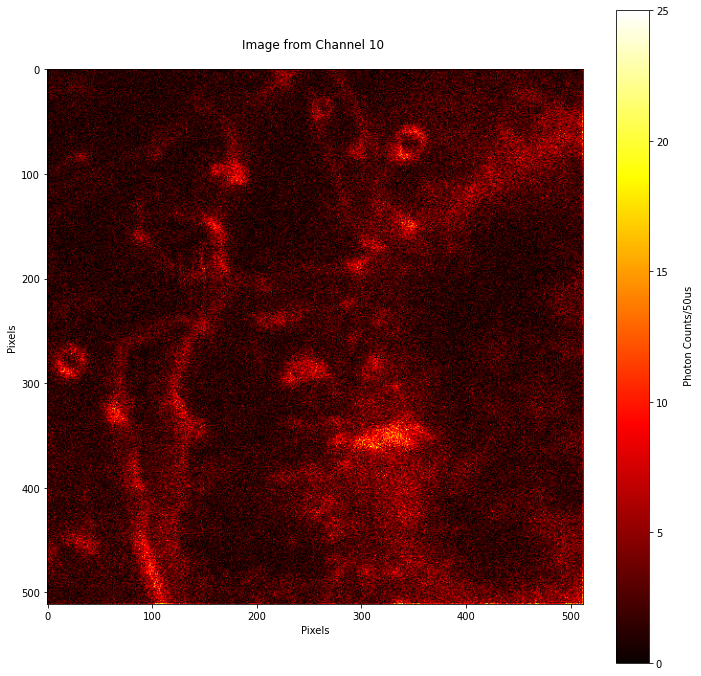

In [28]:
channel=10
ch=channel-1
# 3D dataset
data_3d_channel_10=image_4d[:,:,:,ch]
# x-y image
image_channel_10=data_3d_channel_10.sum(axis=2)

fig= plt.figure(figsize=(12,12))
plt.imshow(image_channel_10, cmap='hot')

cbar = plt.colorbar()
cbar.set_label('\n Photon Counts/'+str(dwell_time)+'us')
title('Image from Channel '+str(ch+1)+' \n')
xlabel('Pixels')
ylabel('Pixels')